In [4]:
from common.torch_utils import get_available_device

device = get_available_device()

Platform: Darwin
Release: 21.5.0
MPS available: True
CUDA available: False
Selected device: mps


## Model

In [5]:
from fcos import FCOS
from fcos import build_backbone
from dataset import LabelsCodec

target_resolution = (256, 256)
model = FCOS(
    backbone=build_backbone('resnet50'),
    labels_codec=LabelsCodec(),
    res=target_resolution,
)

## Dataloader

In [7]:
from dataset.loader import build_dataloader

train_dataloader = build_dataloader('train', batch_size=4)
img, boxes, labels = next(iter(train_dataloader))
print(img.shape)
print(boxes)
print(labels)

torch.Size([4, 256, 256, 3])
[tensor([[  0.0000,  23.2107, 256.0000, 256.0000]]), tensor([[188.7380, 102.7879, 256.0000, 154.5051],
        [ 75.6880,  73.0505, 124.7840, 177.1313],
        [ 56.9540, 121.5354,  95.7140, 193.9394],
        [  7.8580,  35.5556,  97.6520, 175.8384],
        [  0.0000,   0.6465, 178.4020,  75.6364]]), tensor([[ 67.5840, 121.1700, 253.9520, 256.0000]]), tensor([[216.0625, 189.6824, 233.1625, 231.7549],
        [ 99.9250, 147.6100, 112.0375, 176.8468],
        [119.1625,  56.3343, 235.3000, 211.7883],
        [  0.0000,  94.1281, 122.0125, 184.6908]])]
[tensor([6], dtype=torch.int32), tensor([15, 17, 17,  0, 11], dtype=torch.int32), tensor([8], dtype=torch.int32), tensor([1, 1, 0, 0], dtype=torch.int32)]


/Users/iolkhovsky/Documents/repos/fcos/dataset/loader.py:59: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:233.)
  return torch.Tensor(images), bboxes, labels


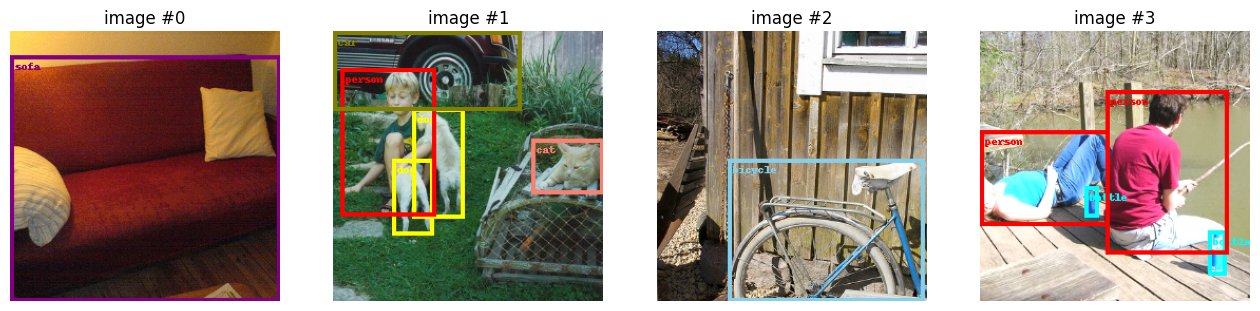

In [8]:
from dataset.visualization import visualize_batch
from dataset.labels_codec import LabelsCodec

visualize_batch(img, boxes, labels, codec=LabelsCodec())

In [9]:
pred = model(img)

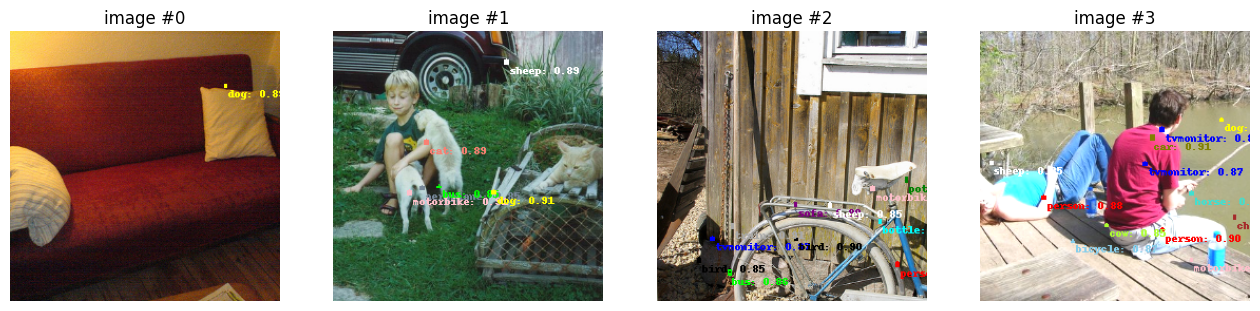

In [10]:
import torch


def draw_predictions(imgs_batch, prediction, labels_codec, threshold=0.01):  
    boxes = [[] for i in range(len(imgs_batch))]
    labels = [[] for i in range(len(imgs_batch))]
    scores = [[] for i in range(len(imgs_batch))]

    for fmap, map_pred in prediction.items():
        pred_classes = map_pred['classes']
        pred_center = map_pred['centerness']
        pred_boxes = map_pred['boxes']

        for img_idx in range(len(pred_classes)):
            img_classes = pred_classes[img_idx]
            img_centerness = pred_center[img_idx]
            img_boxes = pred_boxes[img_idx]
            
            final_scores = img_classes * img_centerness
            max_scores, max_indices = torch.max(final_scores, axis=1)
            mask = max_scores > threshold

            filtered_scores = max_scores[mask]
            filtered_labels = max_indices[mask]
            filtered_boxes = img_boxes[mask]
            
            for score, label, box in zip(filtered_scores, filtered_labels, filtered_boxes):
                scores[img_idx].append(score)
                labels[img_idx].append(label)
                boxes[img_idx].append(box)

    boxes = [
        torch.stack(img_boxes) if len(img_boxes) else torch.zeros((0, 4), dtype=torch.float)
        for img_boxes in boxes
    ]
    scores = [
        torch.stack(img_scores) if len(img_scores) else torch.zeros((0, 1), dtype=torch.float)
        for img_scores in scores
    ]  
    labels = [
        torch.stack(img_labels) if len(img_labels) else torch.zeros((0, 1), dtype=torch.float)
        for img_labels in labels
    ]

    visualize_batch(
        imgs_batch,
        boxes_batch=boxes,
        labels_batch=labels,
        scores_batch=scores,
        codec=labels_codec
    )
            


draw_predictions(img, pred, LabelsCodec(), 0.85)

## Loss function

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class FocalLoss(nn.Module):

    def __init__(self, alpha=0.25, gamma=2, apply_sigmoid=False):
        super(FocalLoss, self).__init__()
        self._alpha = alpha
        self._gamma = gamma
        self._apply_sigmoid = apply_sigmoid

    def forward(self, pred, target):
        if self._apply_sigmoid:
            pred = pred.sigmoid()
        ce = F.binary_cross_entropy(pred, target, reduction='none')
        alpha = target * self._alpha + (1. - target) * (1. - self._alpha)
        pt = torch.where(target == 1,  pred, 1 - pred)
        return alpha * (1. - pt) ** self._gamma * ce

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class CenternessLoss(nn.Module):

    def __init__(self):
        super(CenternessLoss, self).__init__()
        self._criterion = nn.BCELoss(reduction='none')

    def forward(self, pred, target):
        return self._criterion(pred, target)

In [48]:
import torchvision
from fcos import FcosDetectionsCodec


def total_loss(pred, target):
    # targets
    target_classes, target_centerness, target_boxes = target
    all_fmaps = list(target_classes.keys())
    
    first_map = all_fmaps[0]

    b, c, h, w = target_classes[first_map].shape
    target_classes = torch.cat(
        [
            torch.permute(torch.reshape(v, [b, c, -1]), [0, 2, 1]) for k, v in target_classes.items()
        ],
        axis=1
    )

    b, c, h, w = target_centerness[first_map].shape
    target_centerness = torch.cat(
        [
            torch.permute(torch.reshape(v, [b, c, -1]), [0, 2, 1]) for k, v in target_centerness.items()
        ],
        axis=1
    )

    b, c, h, w = target_boxes[first_map].shape
    target_boxes = torch.cat(
        [
            torch.permute(torch.reshape(v, [b, c, -1]), [0, 2, 1]) for k, v in target_boxes.items()
        ],
        axis=1
    )

    # prediction
    pred_classes = torch.cat(
        [
            pred[map_name]['classes'] for map_name in all_fmaps
        ],
        axis=1
    )

    pred_centerness = torch.cat(
        [
            pred[map_name]['centerness'] for map_name in all_fmaps
        ],
        axis=1
    )

    pred_boxes = torch.cat(
        [
            pred[map_name]['boxes'] for map_name in all_fmaps
        ],
        axis=1
    )

    # loss
    print(f"Classes (pred / target): {pred_classes.shape} {target_classes.shape}")
    print(f"Centerness (pred / target): {pred_centerness.shape} {target_centerness.shape}")
    print(f"Boxes (pred / target): {pred_boxes.shape} {target_boxes.shape}")
    
    positive_samples = torch.sum(target_classes, axis=-1)  
    positive_mask = positive_samples > 0
    positive_samples_cnt = torch.sum(positive_mask)
    print("Positive samples cnt:", positive_samples_cnt)
    
    fl_criterion = FocalLoss()
    class_loss = fl_criterion(
        pred_classes,
        target_classes
    )
    class_loss = torch.sum(class_loss) / positive_samples_cnt

    cntr_criterion = CenternessLoss()
    centerness_loss = cntr_criterion(pred_centerness, target_centerness)
    centerness_loss = torch.sum(centerness_loss) / positive_samples_cnt

    pred_boxes_positive = torch.reshape(pred_boxes[positive_mask], [-1, 4])
    target_boxes_positive = torch.reshape(target_boxes[positive_mask], [-1, 4])
    
    for b in pred_boxes_positive:
        print(b)
        x1, y1, x2, y2 = b[0], b[1], b[2], b[3]
        assert (x2 >= x1) and (y2 >= y1)
    
    regression_loss = torchvision.ops.complete_box_iou_loss(
        boxes1=pred_boxes_positive,
        boxes2=target_boxes_positive,
    )
    print("\n\n\n\n")
    print(pred_boxes_positive[2])
    print(target_boxes_positive[2])
    regression_loss = torch.sum(regression_loss)

    return class_loss, centerness_loss, regression_loss
    

img_res = (256, 256)
labels_codec = LabelsCodec()
codec = FcosDetectionsCodec(img_res, labels_codec)

targets = codec.encode(boxes, labels)
res = total_loss(pred, targets)
print("Loss", res)

Classes (pred / target): torch.Size([4, 1364, 20]) torch.Size([4, 1364, 20])
Centerness (pred / target): torch.Size([4, 1364, 1]) torch.Size([4, 1364, 1])
Boxes (pred / target): torch.Size([4, 1364, 4]) torch.Size([4, 1364, 4])
Positive samples cnt: tensor(113)
tensor([32.0000, 31.3436, 33.5016, 32.0000], grad_fn=<UnbindBackward0>)
tensor([96.0000, 32.0000, 96.9096, 32.3567], grad_fn=<UnbindBackward0>)
tensor([160.,  32., 160.,  32.], grad_fn=<UnbindBackward0>)
tensor([224.0000,  31.9923, 224.0000,  32.1898], grad_fn=<UnbindBackward0>)
tensor([31.8441, 95.6848, 33.0559, 96.0000], grad_fn=<UnbindBackward0>)
tensor([95.9112, 96.0000, 96.8380, 96.0000], grad_fn=<UnbindBackward0>)
tensor([159.7226,  96.0000, 161.8067,  96.4709], grad_fn=<UnbindBackward0>)
tensor([223.7721,  96.0000, 224.0379,  96.0000], grad_fn=<UnbindBackward0>)
tensor([ 32.0000, 159.0773,  32.1389, 160.6459], grad_fn=<UnbindBackward0>)
tensor([ 94.9808, 159.7595,  97.9645, 160.5158], grad_fn=<UnbindBackward0>)
tensor([15

### Classification (Focal)

### Regression (IoU)

### Centerness (BCE)